<a href="https://colab.research.google.com/github/nathandsouza10/trading_bot/blob/experiment/experiment/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [648]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim

import random

In [649]:
!pip install alpaca-py

In [650]:
device = ('cuda' if torch.cuda.is_available() else 'cpu')
device

'cuda'

In [651]:
np.random.seed(20)
torch.manual_seed(20)
random.seed(20)

In [652]:
from alpaca.data.historical import CryptoHistoricalDataClient
from alpaca.data.requests import CryptoBarsRequest
from alpaca.data.timeframe import TimeFrame
from datetime import datetime

# no keys required for crypto data
client = CryptoHistoricalDataClient()
#"BTC/USD" "LINK/USD",
stocks = [ "DAI/USD", "ETH/USD", "LINK/USD"]

request_params = CryptoBarsRequest(
                        symbol_or_symbols=stocks,
                        timeframe=TimeFrame.Day,
                        start=datetime(1600, 7, 1),
                        end=datetime(2022, 9, 1)
                 )

bars = client.get_crypto_bars(request_params)

# convert to dataframe
bars.df

open    high     low   close     volume  \
symbol   timestamp                                                              
DAI/USD  2021-01-01 06:00:00+00:00  1.0050  1.0060  1.0040  1.0043  138550.62   
         2021-01-02 06:00:00+00:00  1.0048  1.0051  1.0010  1.0023  135259.08   
         2021-01-03 06:00:00+00:00  1.0017  1.0055  1.0010  1.0033  512113.31   
         2021-01-04 06:00:00+00:00  1.0043  1.0065  1.0006  1.0017  493462.81   
         2021-01-05 06:00:00+00:00  1.0015  1.0031  1.0009  1.0030   40527.98   
...                                    ...     ...     ...     ...        ...   
LINK/USD 2022-08-27 05:00:00+00:00  6.5202  6.6077  6.4171  6.4791   65050.55   
         2022-08-28 05:00:00+00:00  6.4791  6.6266  6.2025  6.3232  109749.98   
         2022-08-29 05:00:00+00:00  6.3368  6.8218  6.2835  6.7760  203058.98   
         2022-08-30 05:00:00+00:00  6.7754  6.8321  6.3660  6.7995  157433.73   
         2022-08-31 05:00:00+00:00  6.7959  6.8896  6.4967  6.5894  103873.34   

                                    trade_count      vwap  
symbol   timestamp                                         
DAI/USD  2021-01-01 06:00:00+00:00         86.0  1.005070  
         2021-01-02 06:00:00+00:00        145.0  1.003017  
         2021-01-03 06:00:00+00:00        279.0  1.002611  
         2021-01-04 06:00:00+00:00        365.0  1.001975  
         2021-01-05 06:00:00+00:00         60.0  1.002023  
...                                         ...       ...  
LINK/USD 2022-08-27 05:00:00+00:00       1671.0  6.514891  
         2022-08-28 05:00:00+00:00       2738.0  6.378791  
         2022-08-29 05:00:00+00:00       3068.0  6.599441  
         2022-08-30 05:00:00+00:00       2894.0  6.677016  
         2022-08-31 05:00:00+00:00       2499.0  6.698036  

[1824 rows x 7 columns]

In [653]:
data = bars.df.loc['ETH/USD']
data[['close']]

,close
timestamp,
2021-01-01 06:00:00+00:00,733.65
2021-01-02 06:00:00+00:00,786.88
2021-01-03 06:00:00+00:00,1086.86
2021-01-04 06:00:00+00:00,991.40
2021-01-05 06:00:00+00:00,1105.56
...,...
2022-08-27 05:00:00+00:00,1487.49
2022-08-28 05:00:00+00:00,1449.34
2022-08-29 05:00:00+00:00,1582.42


In [654]:
from sklearn.preprocessing import MinMaxScaler
price = data[['close']]
scaler = MinMaxScaler(feature_range=(0, 1))
price['close'] = scaler.fit_transform(price['close'].values.reshape(-1,1))
price

<ipython-input-654-09b0e32de3f7>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  price['close'] = scaler.fit_transform(price['close'].values.reshape(-1,1))


,close
timestamp,
2021-01-01 06:00:00+00:00,0.000000
2021-01-02 06:00:00+00:00,0.013002
2021-01-03 06:00:00+00:00,0.086272
2021-01-04 06:00:00+00:00,0.062956
2021-01-05 06:00:00+00:00,0.090840
...,...
2022-08-27 05:00:00+00:00,0.184127
2022-08-28 05:00:00+00:00,0.174809
2022-08-29 05:00:00+00:00,0.207314


In [655]:
def split_data(stock, lookback, test_size=0.2):
    data_raw = stock.to_numpy() # convert to numpy array
    data = []

    # create all possible sequences of length seq_len
    for index in range(len(data_raw) - lookback):
        data.append(data_raw[index: index + lookback])

    data = np.array(data);
    test_set_size = int(np.round(test_size*data.shape[0]));
    train_set_size = data.shape[0] - (test_set_size);

    x_train = data[:train_set_size,:-1,:]
    y_train = data[:train_set_size,-1,:]

    x_test = data[train_set_size:,:-1]
    y_test = data[train_set_size:,-1,:]

    return x_train, y_train, x_test, y_test
lookback = 10 # choose sequence length
x_train, y_train, x_test, y_test = split_data(price, lookback, test_size=0.3)

x_test.shape

(179, 9, 1)

In [656]:
x_train = torch.from_numpy(x_train).type(torch.Tensor).to(device)
x_test = torch.from_numpy(x_test).type(torch.Tensor).to(device)
y_train_lstm = torch.from_numpy(y_train).type(torch.Tensor).to(device)
y_test_lstm = torch.from_numpy(y_test).type(torch.Tensor).to(device)

In [657]:
input_dim = 1
hidden_dim = 32
num_layers = 2
output_dim = 1
num_epochs = 6000

In [658]:
class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers

        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Sequential(
                        nn.Linear(hidden_dim, hidden_dim // 2 ),
                        nn.Tanh(),
                        nn.Linear(hidden_dim // 2, hidden_dim // 4),
                        nn.ReLU(),
                        nn.Linear(hidden_dim // 4, output_dim)
                )


    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_().to(device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_().to(device)
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
        out = self.fc(out[:, -1, :])
        return out

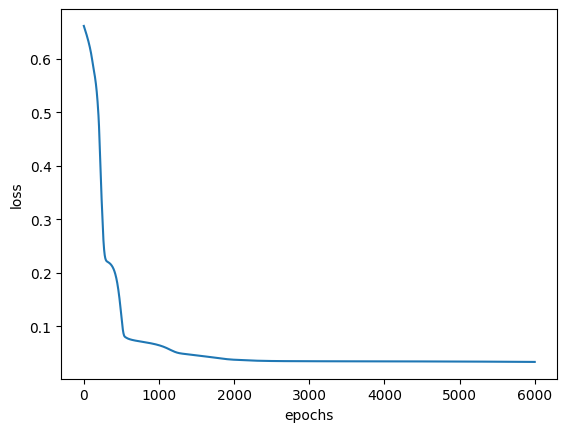

last train loss: 0.03323189541697502


In [659]:
model = LSTM(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers)
model = model.to(device)
criterion = torch.nn.MSELoss()
optimiser = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)

hist = np.zeros(num_epochs)
for t in range(num_epochs):
    y_train_pred = model(x_train)
    loss = torch.sqrt(criterion(y_train_pred, y_train_lstm))
    hist[t] = loss.item()
    optimiser.zero_grad()
    loss.backward()
    optimiser.step()
plt.plot([i for i in range(1, num_epochs+1)], hist)
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()
print(f"last train loss: {hist[-1]}")

In [660]:
with torch.no_grad():
    y_pred = model(x_test)


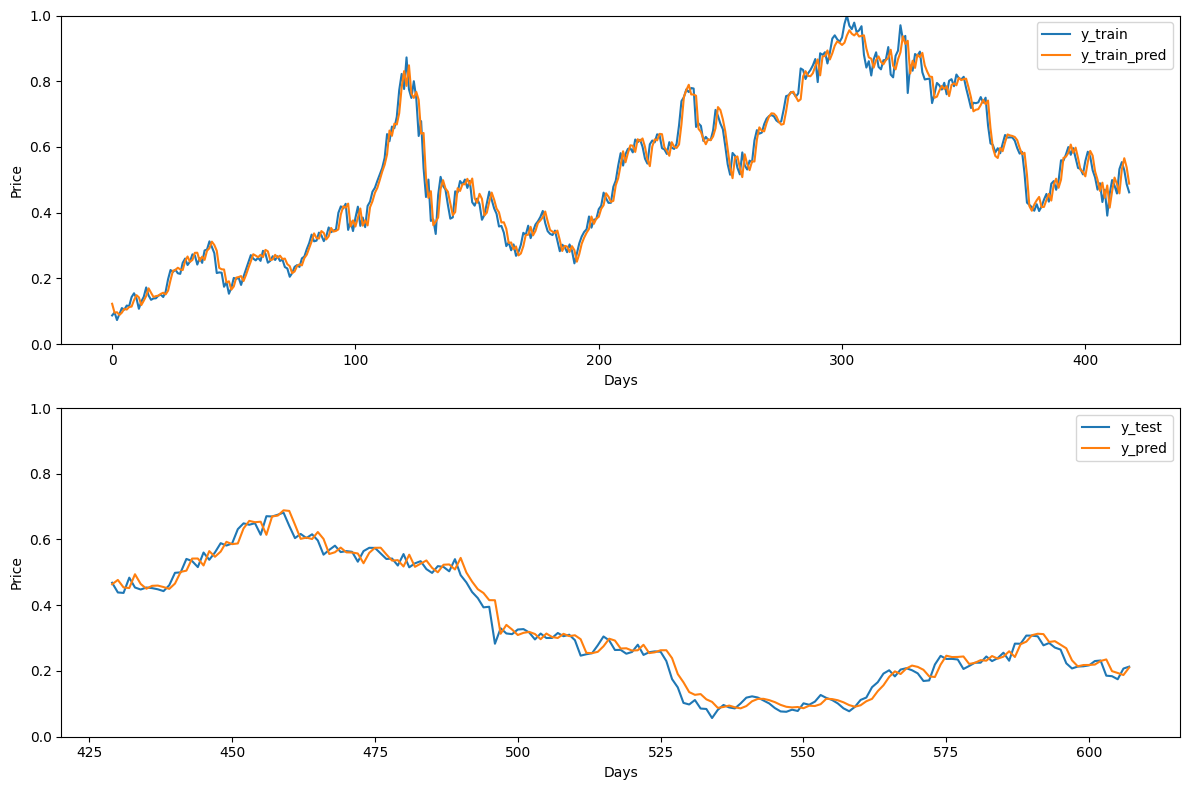

In [661]:
fig, axs = plt.subplots(2, 1, figsize=(12, 8))

# Plot the first set of graphs in the first subplot
axs[0].plot([i for i in range(0, len(y_train))], y_train, label='y_train')
axs[0].plot([i for i in range(0, len(y_train_pred))], y_train_pred.cpu().detach(), label='y_train_pred')
axs[0].set_xlabel("Days")
axs[0].set_ylabel("Price")
axs[0].legend()
axs[0].set_ylim(0, 1)

# Plot the second set of graphs in the second subplot
axs[1].plot([i for i in range(len(price)-len(x_test), len(price))], y_test, label='y_test')
axs[1].plot([i for i in range(len(price)-len(x_test), len(price))], y_pred.cpu(), label='y_pred')
axs[1].set_xlabel("Days")
axs[1].set_ylabel("Price")
axs[1].legend()
axs[1].set_ylim(0, 1)

# Adjust the spacing between subplots
plt.tight_layout()

# Display the figure
plt.show()

In [662]:
closing_price_df = pd.DataFrame()
for stock in stocks:
    closing_price_df[stock] = bars.df.loc[stock]['close']
closing_price_df

,DAI/USD,ETH/USD,LINK/USD
timestamp,,,
2021-01-01 06:00:00+00:00,1.0043,733.65,11.7660
2021-01-02 06:00:00+00:00,1.0023,786.88,12.0256
2021-01-03 06:00:00+00:00,1.0033,1086.86,15.2500
2021-01-04 06:00:00+00:00,1.0017,991.40,13.2304
2021-01-05 06:00:00+00:00,1.0030,1105.56,14.4115
...,...,...,...
2022-08-27 05:00:00+00:00,0.9999,1487.49,6.4791
2022-08-28 05:00:00+00:00,0.9998,1449.34,6.3232
2022-08-29 05:00:00+00:00,0.9999,1582.42,6.7760


In [663]:
log_returns = np.log(closing_price_df/closing_price_df.shift(1))
portfolio_returns = []
portfolio_volatilities = []
for x in range(1000):
    weights = np.random.random(len(stocks))
    weights /= np.sum(weights)
    portfolio_returns.append(np.sum(weights * log_returns.mean()) * 365)
    portfolio_volatilities.append(np.sqrt(np.dot(weights.T, np.dot(log_returns.cov() * 365, weights))))

portfolio_returns = np.array(portfolio_returns)
portfolio_volatilities = np.array(portfolio_volatilities)

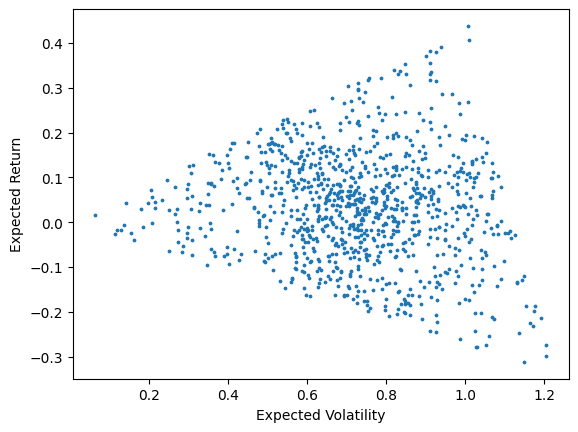

In [664]:
portfolios = pd.DataFrame({'Return': portfolio_returns, 'Volatility':portfolio_volatilities })
plt.scatter(portfolios['Volatility'], portfolios['Return'], s=3)
plt.xlabel('Expected Volatility')
plt.ylabel('Expected Return')
plt.show()